In [ ]:
import pandas as pd
import os
from google.colab import drive
from scipy import stats
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Psychologia/Magisterka/magisterka Psyche/Mateusz_Kamyczura_Praca_Magisterska/Kody/Baza danych'
Output_path = path + '/Output'

Mounted at /content/drive


In [ ]:
ABC = pd.read_excel(Output_path + '/ABC.xlsx')
XYZ = pd.read_excel(Output_path + '/XYZ.xlsx')

In [ ]:
def porownaj_grupy(df1, df2, kolumna, nazwa1='Grupa 1', nazwa2='Grupa 2'):
    def statystyki(df, kolumna):
        return {
            'Liczność': len(df),
            'Mediana': df[kolumna].median(),
            'Średnia': df[kolumna].mean(),
            'Rozstęp': df[kolumna].max() - df[kolumna].min(),
            'Odchylenie standardowe': df[kolumna].std(),
            'Skośność': stats.skew(df[kolumna]),
            'Kurtoza': stats.kurtosis(df[kolumna])
        }

    # Obliczenie statystyk dla obu grup
    statystyki_grupa1 = statystyki(df1, kolumna)
    statystyki_grupa2 = statystyki(df2, kolumna)

    # Tworzenie tabeli wyników
    wynik = pd.DataFrame([statystyki_grupa1, statystyki_grupa2], index=[nazwa1, nazwa2])

    return wynik

In [ ]:
porownaj_grupy(ABC, XYZ, "ProcentPoprawnych", "ABC", "XYZ")

,Liczność,Mediana,Średnia,Rozstęp,Odchylenie standardowe,Skośność,Kurtoza
ABC,42,85.714286,84.188289,44.444444,11.077134,-0.675095,-0.316284
XYZ,41,64.285714,64.795749,43.809524,9.854192,0.071744,0.135125


In [ ]:
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis

def test_normalnosci_i_t(df1, df2, kolumna, nazwa1="Grupa 1", nazwa2="Grupa 2"):
    print("=== Testy wstępne ===")

    # Test Shapiro-Wilka dla normalności
    stat1 = stats.shapiro(df1[kolumna])
    stat2 = stats.shapiro(df2[kolumna])
    p1 = stat1.pvalue
    p2 = stat2.pvalue

    print(f"{nazwa1} - Shapiro-Wilk: p = {p1:.4f} → {'normalny' if p1 > 0.05 else 'nienormalny'}")
    print(f"{nazwa2} - Shapiro-Wilk: p = {p2:.4f} → {'normalny' if p2 > 0.05 else 'nienormalny'}")

    # Test Levene’a na jednorodność wariancji
    levene = stats.levene(df1[kolumna], df2[kolumna])
    print(f"\nTest Levene’a (jednorodność wariancji): F = {levene.statistic:.2f}, p = {levene.pvalue:.4f} → {'jednorodne' if levene.pvalue > 0.05 else 'niejednorodne'}")

    # Czy dane są normalne?
    normalne = p1 > 0.05 and p2 > 0.05

    # Jeśli nie, sprawdzamy kurtozę i skośność
    if not normalne:
        print("\nRozkłady nie są normalne. Sprawdzamy kurtozę i skośność jako dodatkowe kryteria:")
        sk1 = skew(df1[kolumna])
        sk2 = skew(df2[kolumna])
        kurt1 = kurtosis(df1[kolumna])
        kurt2 = kurtosis(df2[kolumna])

        print(f"{nazwa1} - skośność = {sk1:.2f}, kurtoza = {kurt1:.2f}")
        print(f"{nazwa2} - skośność = {sk2:.2f}, kurtoza = {kurt2:.2f}")

        if all(abs(val) <= 1 for val in [sk1, sk2]) and all(abs(val) <= 2 for val in [kurt1, kurt2]):
            print("Skośność i kurtoza są w akceptowalnym zakresie → dopuszczamy test t.")
            normalne = True
        else:
            print("Skośność lub kurtoza przekraczają dopuszczalne wartości → nie przeprowadzamy testu t.")

    # Jeśli wszystko gra – robimy test t
    if normalne:
        equal_var = levene.pvalue > 0.05
        test_t = stats.ttest_ind(df1[kolumna], df2[kolumna], equal_var=equal_var)
        test_t_result = f"Test t-Studenta ({nazwa1} vs {nazwa2}): statystyka = {test_t.statistic:.4f}, p = {test_t.pvalue:.4f} → {'istotna różnica' if test_t.pvalue < 0.05 else 'brak istotnej różnicy'}"

        # Obliczanie Cohen's d
        mean1 = df1[kolumna].mean()
        mean2 = df2[kolumna].mean()
        std1 = df1[kolumna].std(ddof=1)
        std2 = df2[kolumna].std(ddof=1)
        n1 = len(df1[kolumna])
        n2 = len(df2[kolumna])
        pooled_std = np.sqrt(((n1 - 1)*std1**2 + (n2 - 1)*std2**2) / (n1 + n2 - 2))
        cohens_d = (mean1 - mean2) / pooled_std

        print("\n=== Wynik testu t ===")
        print(test_t_result)
        print(f"Cohen's d = {cohens_d:.2f} → {'mały' if abs(cohens_d) < 0.2 else 'średni' if abs(cohens_d) < 0.8 else 'duży'} efekt")

    else:
        test_t_result = "Nie przeprowadzono testu t (dane niespełniają założeń)."
        cohens_d = None

    return {
        f"Shapiro-Wilk p {nazwa1}": p1,
        f"Shapiro-Wilk p {nazwa2}": p2,
        "Levene p": levene.pvalue,
        "Test t wynik": test_t_result,
        "Cohen's d": cohens_d
    }


In [ ]:
test_normalnosci_i_t(ABC, XYZ, "ProcentPoprawnych", "ABC", "XYZ")

=== Testy wstępne ===
ABC - Shapiro-Wilk: p = 0.0216 → nienormalny
XYZ - Shapiro-Wilk: p = 0.6962 → normalny

Test Levene’a (jednorodność wariancji): F = 0.35, p = 0.5556 → jednorodne

Rozkłady nie są normalne. Sprawdzamy kurtozę i skośność jako dodatkowe kryteria:
ABC - skośność = -0.68, kurtoza = -0.32
XYZ - skośność = 0.07, kurtoza = 0.14
Skośność i kurtoza są w akceptowalnym zakresie → dopuszczamy test t.

=== Wynik testu t ===
Test t-Studenta (ABC vs XYZ): statystyka = 8.4196, p = 0.0000 → istotna różnica
Cohen's d = 1.85 → duży efekt


{'Shapiro-Wilk p ABC': np.float64(0.02159596214248869),
 'Shapiro-Wilk p XYZ': np.float64(0.6962313220095673),
 'Levene p': np.float64(0.5555614840509102),
 'Test t wynik': 'Test t-Studenta (ABC vs XYZ): statystyka = 8.4196, p = 0.0000 → istotna różnica',
 "Cohen's d": np.float64(1.8484852313794626)}

In [ ]:
def narysuj_histogram_boczny_z_kde(df1, df2, kolumna, nazwa1="Grupa 1", nazwa2="Grupa 2", bins=20):
    """
    Rysuje histogram z podziałem na dwie grupy, słupki obok siebie + KDE.

    Argumenty:
    - df1, df2: DataFrame’y z daną kolumną
    - kolumna: kolumna do porównania
    - nazwa1, nazwa2: etykiety grup
    - bins: liczba słupków
    """
    plt.figure(figsize=(10, 6))

    # Dane
    dane1 = df1[kolumna].dropna()
    dane2 = df2[kolumna].dropna()

    # Wspólne biny
    all_data = np.concatenate([dane1, dane2])
    counts1, bin_edges = np.histogram(dane1, bins=bins, range=(all_data.min(), all_data.max()))
    counts2, _ = np.histogram(dane2, bins=bin_edges)

    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2

    # Przesuwamy słupki
    offset = bin_width / 4
    plt.bar(bin_centers - offset, counts1 / len(dane1), width=bin_width/2, label=nazwa1, color='skyblue', alpha=0.7)
    plt.bar(bin_centers + offset, counts2 / len(dane2), width=bin_width/2, label=nazwa2, color='salmon', alpha=0.7)

    # KDE
    kde1 = gaussian_kde(dane1)
    kde2 = gaussian_kde(dane2)
    x = np.linspace(all_data.min(), all_data.max(), 500)
    plt.plot(x, kde1(x), color='blue', linestyle='--', label=f"KDE - {nazwa1}")
    plt.plot(x, kde2(x), color='red', linestyle='--', label=f"KDE - {nazwa2}")

    #plt.title(f"Histogram porównawczy procenta poprawnych rozpoznań z KDE")
    plt.xlabel("Procent poprawnych rozpoznań")
    plt.ylabel("Liczba obserwacji (znormalizowana)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


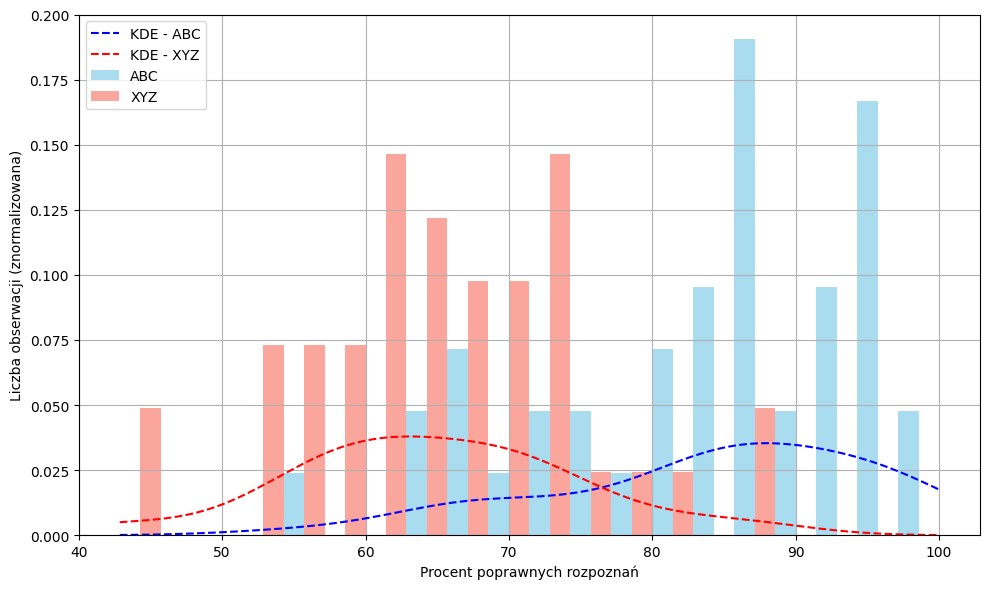

In [ ]:
narysuj_histogram_boczny_z_kde(ABC, XYZ, "ProcentPoprawnych", "ABC", "XYZ")

In [ ]:
PoprawnoscPytanABC = pd.read_excel(Output_path + '/PoprawnoscPytanABC.xlsx')
PoprawnoscPytanXYZ = pd.read_excel(Output_path + '/PoprawnoscPytanXYZ.xlsx')

In [ ]:
PoprawnoscPytanABC.procent_poprawnych.describe()

,procent_poprawnych
count,28.000000
mean,84.254110
std,9.070699
min,62.500000
25%,78.654971
50%,85.182927
75%,88.414634
max,100.000000


In [ ]:
PoprawnoscPytanABC[PoprawnoscPytanABC['G'] == 0].procent_poprawnych.describe()

,procent_poprawnych
count,14.000000
mean,84.281141
std,7.526221
min,75.609756
25%,78.070175
50%,84.605263
75%,86.966463
max,100.000000


In [ ]:
PoprawnoscPytanABC[PoprawnoscPytanABC['G'] == 1].procent_poprawnych.describe()

,procent_poprawnych
count,14.000000
mean,84.227080
std,10.688247
min,62.500000
25%,81.323631
50%,85.714286
75%,90.418118
max,100.000000


In [ ]:
PoprawnoscPytanXYZ.procent_poprawnych.describe()

,procent_poprawnych
count,30.000000
mean,64.778706
std,20.185719
min,17.948718
25%,53.564189
50%,71.263290
75%,78.990385
max,90.243902


In [ ]:
PoprawnoscPytanXYZ[PoprawnoscPytanXYZ['G'] == 0].procent_poprawnych.describe()

,procent_poprawnych
count,15.000000
mean,64.435678
std,23.745482
min,17.948718
25%,44.802632
50%,74.358974
75%,83.525641
max,90.243902


In [ ]:
PoprawnoscPytanXYZ[PoprawnoscPytanXYZ['G'] == 1].procent_poprawnych.describe()

,procent_poprawnych
count,15.000000
mean,65.121735
std,16.731138
min,20.000000
25%,56.756757
50%,69.230769
75%,74.743261
max,89.743590


In [ ]:
PoprawnoscPytanXYZ.sort_values(by='procent_poprawnych')

,Lp.,-1,0,1,procent_poprawnych,G,Ciąg
16,17,32,2,7,17.948718,0,XYYYZZZZZXY
8,9,32,1,8,20.000000,1,XXXXXXXZZZZZZXY
9,10,29,1,11,27.500000,0,XYYXXZZZZZXY
6,7,22,4,15,40.540541,0,XXXXXXYYZZZZZXY
28,29,22,3,16,42.105263,0,XXZZXY
23,24,21,1,19,47.500000,0,XZZZXY
19,20,21,1,19,47.500000,1,XXZXY
1,2,19,1,21,52.500000,1,XXXXZZZXY
13,14,16,4,21,56.756757,1,XYZXY
29,30,16,4,21,56.756757,1,XXXZZXY


In [ ]:
PoprawnoscPytanABC.sort_values(by='procent_poprawnych')

,Lp.,-1,0,1,procent_poprawnych,G,Ciąg
3,5,15,2,25,62.500000,1,abcabcabcabcab
10,12,13,0,29,69.047619,1,ababcccababab
25,28,11,5,26,70.270270,1,abababccabcab
1,2,10,1,31,75.609756,0,bacbcab
26,29,9,5,28,75.675676,0,abcabbab
0,1,10,0,32,76.190476,0,abccacb
22,25,8,6,28,77.777778,0,abbcab
12,14,8,4,30,78.947368,0,abcabccabcb
18,20,7,5,30,81.081081,1,abcabcccab
7,9,7,3,32,82.051282,1,abcabccab


In [ ]:
def wykres_procentow(df):
    """
    Tworzy wykres procentu poprawnych odpowiedzi dla każdego pytania,
    sortując dane rosnąco po procentach.

    Parametry:
    df (pd.DataFrame): DataFrame zawierający kolumny 'Lp.' i 'procent_poprawnych'
    """
    # Sortowanie danych
    df_sorted = df.sort_values(by='procent_poprawnych', ascending=True)

    # Tworzenie wykresu
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted['Lp.'].astype(str), df_sorted['procent_poprawnych'], color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel('Numer ciągu')
    plt.ylabel('Procent poprawnych odpowiedzi')
    #plt.title('Procent poprawnych odpowiedzi dla każdego ciągu')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

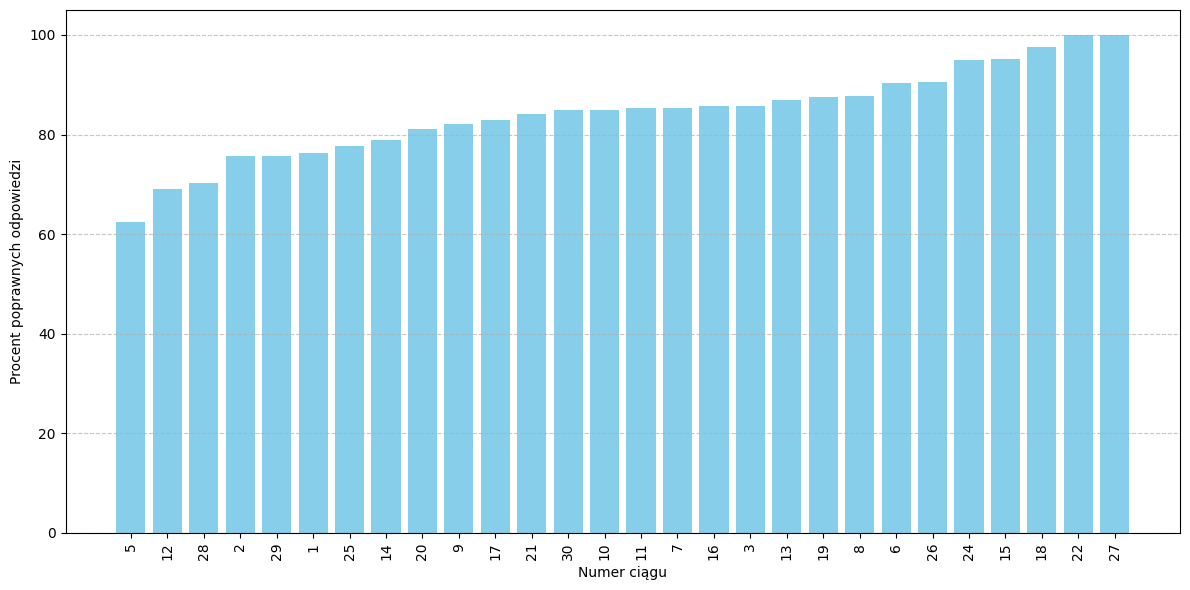

In [ ]:
wykres_procentow(PoprawnoscPytanABC)

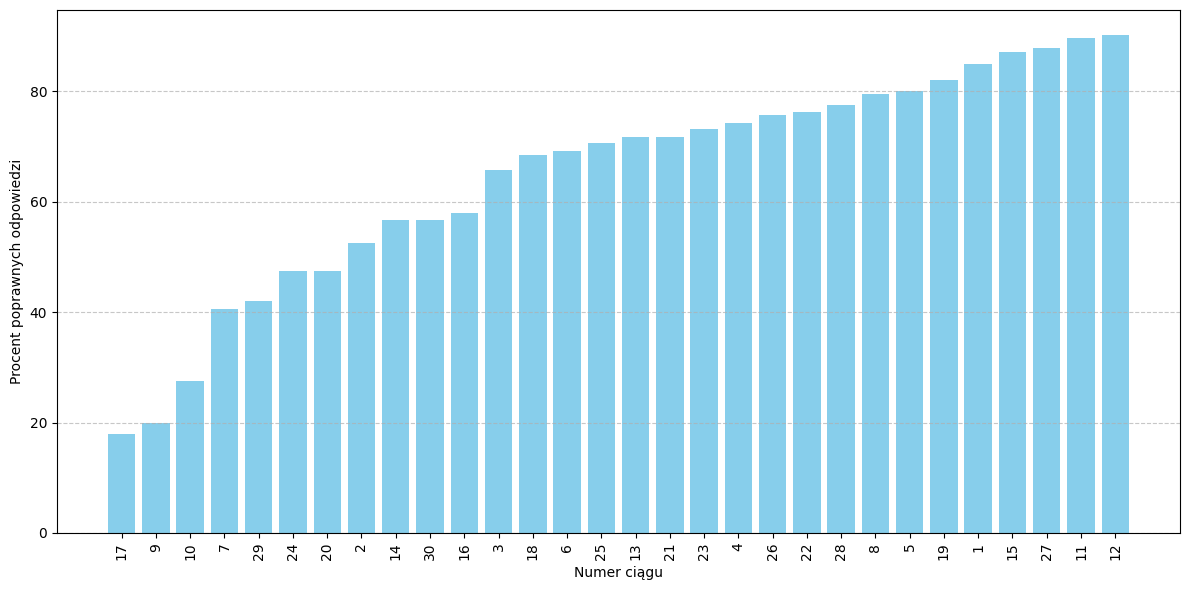

In [ ]:
wykres_procentow(PoprawnoscPytanXYZ)